# Classification NLP : BERT (Hugging Face)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from transformers import TFAutoModel, AutoTokenizer

flipkart = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')
flipkart = flipkart[['uniq_id', 'product_name', 'product_category_tree', 'image', 'description', 'brand']].copy()
flipkart.loc[:, 'product_category'] = flipkart['product_category_tree'].apply(lambda x: x.split(' >> ')[0])
flipkart.loc[:, 'product_category'] = flipkart['product_category'].str.strip('["')

# Configuration de l'environnement TensorFlow
os.environ["TF_KERAS"] = '1'

def features_bert_fct(model_type, model, sentences, mode):
    """
    Extraction des caractéristiques de texte à partir d'un modèle BERT donné.
    """
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    last_hidden_states_tot = None
    
    # Traitement des phrases par lots de 10
    for step in range(len(sentences) // 10):
        idx = step * 10
        input_ids = []
        token_type_ids = []
        attention_mask = []
        for sent in sentences[idx:idx + 10]:
            bert_inp = bert_tokenizer.encode_plus(sent,add_special_tokens=True, max_length=160, padding='max_length',
                                                  return_attention_mask=True, return_token_type_ids=True, truncation=True, 
                                                  return_tensors="tf")
            input_ids.append(bert_inp['input_ids'][0])
            token_type_ids.append(bert_inp['token_type_ids'][0])
            attention_mask.append(bert_inp['attention_mask'][0])
        input_ids = np.asarray(input_ids)
        token_type_ids = np.asarray(token_type_ids)
        attention_mask = np.array(attention_mask)
        if mode == 'HF':
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=10)
            last_hidden_states = outputs.last_hidden_state
        elif mode == 'TFhub':
            text_preprocessed = {
                "input_word_ids": input_ids,
                "input_mask": attention_mask,
                "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
            
        # Concaténation des états cachés
        if step == 0:
            last_hidden_states_tot = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot, last_hidden_states))
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    return features_bert, last_hidden_states_tot

# Définition des paramètres du modèle
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = flipkart['description'].to_list()

# Extraction des caractéristiques BERT
bert_features_hf, last_hidden_states_tot = features_bert_fct(model_type, model, sentences, mode="HF")

C:\Users\Alex-\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

1/1 [==============================] - 2s 2s/step


## Régression Logistique

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

def predict_fct(features):
    """
    Effectue une prédiction de la catégorie de produit en utilisant la 
    régression logistique, et affiche l'accuracy et un rapport de classification.
    """
    X_train, X_test, y_train, y_test = train_test_split(features, flipkart['product_category'], test_size=0.2, 
                                                        random_state=42)
    # Initialisation et entraînement du modèle
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    # Prédiction et évaluation du modèle
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Application de la fonction de prédiction avec les features BoW
predict_fct(bert_features_hf)

Accuracy: 0.9333333333333333

Classification Report:
                            precision    recall  f1-score   support

                 Baby Care       0.88      0.78      0.82        27
  Beauty and Personal Care       1.00      1.00      1.00        21
                 Computers       0.97      0.97      0.97        38
Home Decor & Festive Needs       0.85      0.93      0.89        30
           Home Furnishing       0.91      0.89      0.90        35
          Kitchen & Dining       0.93      0.96      0.94        26
                   Watches       1.00      1.00      1.00        33

                  accuracy                           0.93       210
                 macro avg       0.93      0.93      0.93       210
              weighted avg       0.93      0.93      0.93       210



C:\Users\Alex-\anaconda3\envs\myenv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## T-SNE

CountVectorizer:


C:\Users\Alex-\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI score: 0.3095


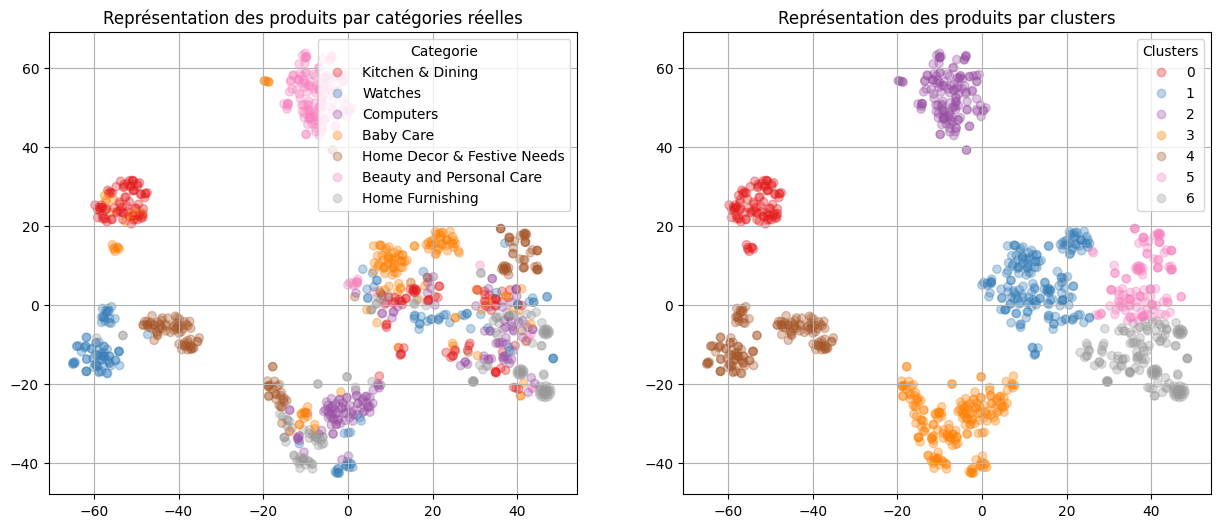

In [35]:
from sklearn import manifold, cluster, metrics
import matplotlib.pyplot as plt

# Liste des catégories uniques
l_cat = list(set(flipkart['product_category']))
# Conversion des catégories en valeurs numériques
y_cat_num = [(1 - l_cat.index(flipkart.iloc[i]['product_category'])) for i in range(len(flipkart))]

# Fonction de visualisation avec t-SNE
def tsne_visu_fct(features):
    """
    Effectue une réduction dimensionnelle avec t-SNE et visualise les catégories réelles et les clusters.
    """
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Clustering avec KMeans
    cls = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    # Calcul de l'ARI (Adjusted Rand Index)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    print("ARI score:", ARI)
    
    # Visualisation
    fig = plt.figure(figsize=(15, 6))
    
    # Graphique des catégories réelles
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1', alpha=0.33)
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    ax.set_title('Représentation des produits par catégories réelles')
    ax.grid()

    # Graphique des clusters
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cls.labels_, cmap='Set1', alpha=0.33)
    ax.legend(handles=scatter.legend_elements()[0], labels=set(cls.labels_), loc="best", title="Clusters")
    ax.set_title('Représentation des produits par clusters')
    ax.grid()
    
    # Affichage des graphiques
    plt.show()

# Application du t-SNE sur les données BoW et visualisation
print("CountVectorizer:")
tsne_visu_fct(bert_features_hf)

# Classification NLP : MiniLM

In [4]:
from sentence_transformers import SentenceTransformer

# Chargement du modèle all-MiniLM-L6-v2
model = SentenceTransformer("all-MiniLM-L6-v2")

# Fonction d'encodage par lots
def get_miniLM_embeddings_in_batches(sentences, batch_size=10):
    embeddings = []
    
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        batch_embeddings = model.encode(batch, batch_size=batch_size, show_progress_bar=True)
        embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

# Extraction des embeddings avec all-MiniLM-L6-v2
miniLM_embeddings = get_miniLM_embeddings_in_batches(sentences, batch_size=10)

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.95it/s]


## Régression Logistique

In [5]:
predict_fct(miniLM_embeddings)

Accuracy: 0.9476190476190476

Classification Report:
                            precision    recall  f1-score   support

                 Baby Care       1.00      0.70      0.83        27
  Beauty and Personal Care       0.88      1.00      0.93        21
                 Computers       0.97      1.00      0.99        38
Home Decor & Festive Needs       0.85      0.97      0.91        30
           Home Furnishing       0.94      0.97      0.96        35
          Kitchen & Dining       1.00      0.96      0.98        26
                   Watches       1.00      1.00      1.00        33

                  accuracy                           0.95       210
                 macro avg       0.95      0.94      0.94       210
              weighted avg       0.95      0.95      0.95       210



## T-SNE

C:\Users\Alex-\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI score: 0.7119


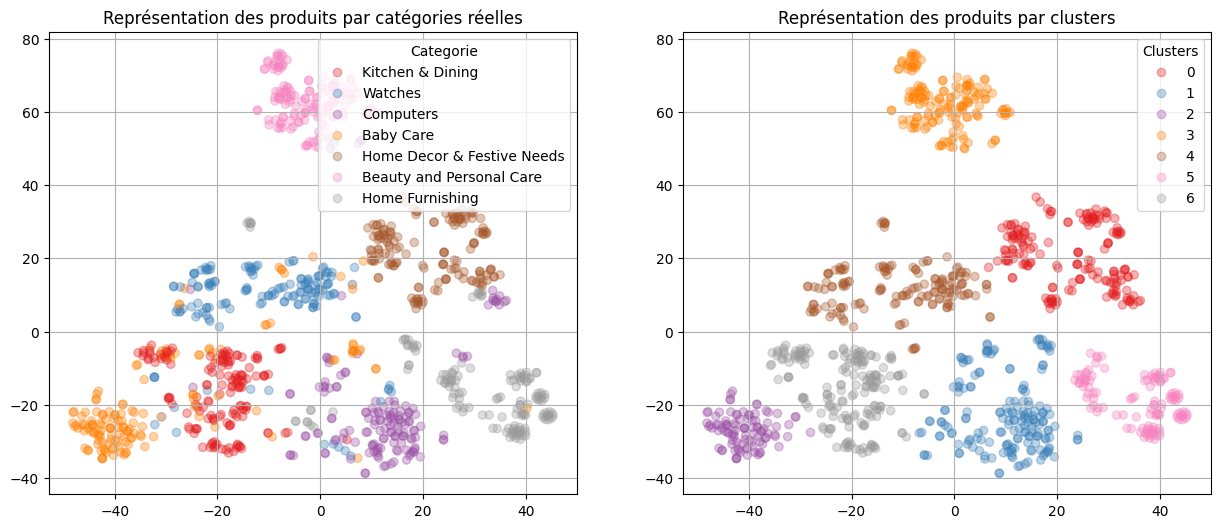

In [36]:
tsne_visu_fct(miniLM_embeddings)